In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from transformers import Dinov2Model

device = torch.device('mps')


/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir     = '/Users/k.choi/Documents/github/csiro_git'
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()

In [3]:
def preprocess_data(df, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
    unqiue_path = df['image_path'].unique()
    data_list = []
    for uni_path in unqiue_path:

        data = df[df['image_path'] == uni_path]
        row   = {'image_path': uni_path} 

        for tar in target_names: 
            row[tar] = data[data['target_name'] == tar]['target'].values[0]
            
        data_list.append(row)   

    return pd.DataFrame(data_list)

In [4]:
data = preprocess_data(csv_data)

train_data, valid_data = train_test_split(data, test_size=0.2, random_state=8964)
train_data, test_data  = train_test_split(train_data, test_size=0.01, random_state=8964)

print(f"train data: {len(train_data)}")
print(f"valid data: {len(valid_data)}")
print(f"test data: {len(test_data)}")


train data: 282
valid data: 72
test data: 3


In [5]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return image, targets


In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

batch_size = 16 
WORKERS = 0

class rand_rota:
    def __call__(self, img):
        angle = np.random.choice([0,90,180,270])
        return transforms.functional.rotate(img, int(angle))

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    rand_rota(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_ds = BiomassDS(df =train_data, data_dir=data_dir, transform=train_transform)
valid_ds = BiomassDS(df =valid_data, data_dir=data_dir, transform=valid_transform)
test_ds  = BiomassDS(df =test_data,  data_dir=data_dir, transform=valid_transform)

assert len(train_ds) == len(train_data) and len(valid_ds) == len(valid_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=True  , pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)

sample_img, sample_target = train_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = valid_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = test_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)


In [7]:
class get_smalldino(nn.Module):

    def __init__(self, backbone, patch_dim = 384, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [8]:
class get_basedino(nn.Module):

    def __init__(self, backbone, patch_dim = 768, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


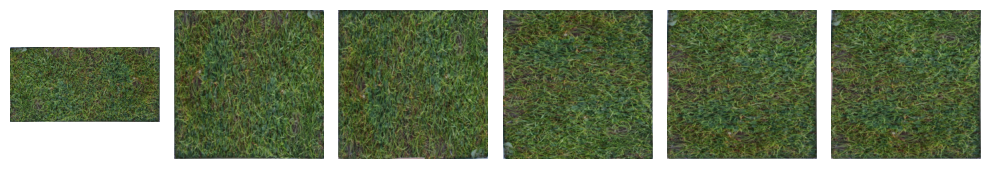

In [9]:
fig, axes = plt.subplots(1,6, figsize=(10,3))
img0 = Image.open(os.path.join(data_dir, random.choice( train_data['image_path'].unique())))

for i, ax in enumerate(axes):
    if i ==0: 
        ax.imshow(img0)
        ax.axis('off')
        continue

    img = train_transform(img0)
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)
    img = img * std + mean
    img = img.clamp(0,1).permute(1,2,0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout();plt.show()

In [10]:
class get_largedino(nn.Module):

    def __init__(self, backbone, patch_dim = 1024, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [11]:
dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small')
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-base')
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-large')
dinov2_backbone.eval()
dinov2_backbone.to(device)

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06,

In [ ]:
model = get_smalldino(dinov2_backbone, patch_dim=384, num_targets=5)
# model = get_basedino(dinov2_backbone, patch_dim=768, num_targets=5)
# model = get_largedino(dinov2_backbone, patch_dim=1024, num_targets=5)
model.to(device)

all_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {all_params}")
train_params = sum(p.numel() for p in model.heads.parameters())
print(f"Trainable parameters: {train_params}")
frozen_params = sum(p.numel() for p in model.backbone.parameters())
print(f"Frozen parameters: {frozen_params}")


Total parameters: 22387845
Trainable parameters: 331269
Frozen parameters: 22056576


In [13]:
LR = 1e-3 
WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
criterion = nn.MSELoss()

In [14]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    num_batches = 0

    pbar = tqdm(loader, desc='Training')

    for img, tar in pbar:
        img = img.to(device)
        tar = tar.to(device)

        optimizer.zero_grad()

        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    return avg_loss

def validate_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0
    num_batches = 0
    
    all_preds = []
    all_targs = []

    with torch.no_grad():

        pbar = tqdm(loader, desc='Validation')
        for img, tar in pbar:
            img = img.to(device)
            tar = tar.to(device)

            pred, _ = model(img)
            loss = criterion(pred, tar)

            total_loss += loss.item()
            num_batches += 1

            all_preds.append(pred.cpu())
            all_targs.append(tar.cpu())

    avg_loss  = total_loss / num_batches
    all_preds = torch.cat(all_preds).numpy()
    all_targs = torch.cat(all_targs).numpy()

    mse  = mean_squared_error(all_targs, all_preds)
    rmse = np.sqrt(mse)
    
    return avg_loss, rmse, all_preds, all_targs
            
    

In [ ]:
NUM_EPOCHS = 100

epoch_counts = 0
best_val = float('inf')
best_model = None

history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
for epoch in range(NUM_EPOCHS):

    train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmse)
    history['learning_rate'].append(current_lr)

    pre_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    history['pre_target_rmse'].append(pre_target_rmse)

    print(f"epoch: {epoch}/{NUM_EPOCHS}")
    print(32 * " -")
    print(f"  train loss: {train_loss:.1f}")
    print(f"  valid loss: {valid_loss:.1f}")
    print(f"  rmse: {rmse:.1f}") 
    print(f"  lr: {current_lr:.6f}")
    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    print(f"  per target rmse: {per_target_rmse}")

    if valid_loss < best_val:
        print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_dinov2_small.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"no val_loss improvement from {best_val:.4f}")

    
    if epoch_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

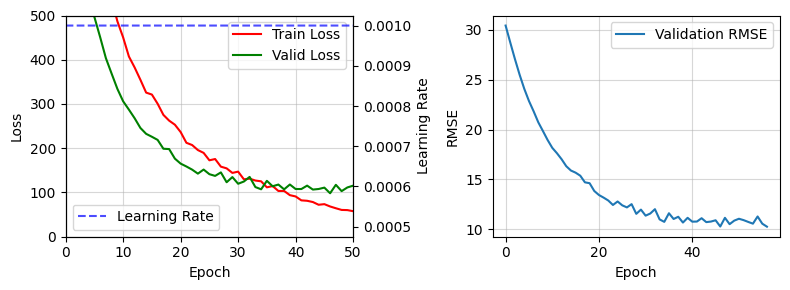

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [20]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [21]:
history_pd = pd.DataFrame(history)
history_pd.to_csv(os.path.join(model_dir, 'history_dinov2_small.csv'), index=False)

In [40]:
def eval_testds(model, loader, device):
    model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model_dinov2_small.pth'))) 
    model.to(device)

    pred_list = []
    targ_list = []

    with torch.no_grad():

        pbar = tqdm(loader, desc='Testing')
        for img, tar in pbar:
            img = img.to(device)
            tar = tar.to(device)

            pred, _ = model(img)
            pred_list.append(pred.cpu())
            targ_list.append(tar.cpu())

        pred_list = torch.cat(pred_list, dim=0).numpy()
        targ_list = torch.cat(targ_list, dim=0).numpy()

    return pred_list, targ_list

model = get_largedino(dinov2_backbone, patch_dim=384, num_targets=5)
pred_list, targ_list = eval_testds(model, test_loader, device)


for i in range(len(test_data)):

    display( pd.DataFrame( { 'predicted': pred_list[i,:], 'target': targ_list[i,:] } ) )
    

Testing: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


,predicted,target
0,10.662700,4.092300
1,8.646290,14.323100
2,35.110043,21.484600
3,54.269226,39.900002
4,44.344940,25.576900


,predicted,target
0,-0.817107,0.0000
1,11.776515,16.3603
2,15.024969,4.5809
3,26.849785,20.9412
4,14.568573,4.5809


,predicted,target
0,-2.767295,1.138500
1,19.239494,18.215401
2,12.099431,13.661500
3,30.388880,33.015400
4,10.432628,14.800000


In [ ]:
model = get_smalldino(dinov2_backbone, patch_dim=384, num_targets=5)
model.load_state_dict( os.path.join (model_dir, 'best_model_dinov2_small.pth') )

TypeError: Expected state_dict to be dict-like, got <class 'str'>.

In [ ]:


# test_loss, test_rmse, all_test_preds, all_test_targs  = validate_epoch(model, test_loader, criterion, device)

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [22]:
print(f"test loss: {test_loss:.1f}")
print(f"test rmse: {test_rmse:.1f}")
print(f"test per target rmse: {np.sqrt(np.mean((all_test_preds - all_test_targs)**2, axis=0))}")

test loss: 103.9
test rmse: 10.2
test per target rmse: [ 2.9716609  5.2155485 13.12905    9.964681  14.552074 ]


In [23]:
len(test_data)

3

In [24]:
for targets in target_names[:1]:
    print(test_data[targets].values)

[4.0923 0.     1.1385]


In [25]:
all_test_preds.shape

(3, 5)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for i , tar in enumerate(target_names):

    true_target = test_data[tar].values
    pred_target = all_test_preds[:, i]

    mse = mean_squared_error(true_target, pred_target) 
    rmse = np.sqrt(mse)
    # r2 = r2_score(true_target, pred_target)
    mae = mean_absolute_error(true_target, pred_target)
    print(f"-- target: {tar}")
    print(f" mean: {np.mean(true_target):.2f}")
    print(f" rmse: {rmse:.2f}")
    # print(f" r2: {r2:.2f}")
    print(f" mae: {mae:.2f}")

-- target: Dry_Clover_g
 mean: 1.74
 rmse: 2.97
 mae: 2.52
-- target: Dry_Dead_g
 mean: 16.30
 rmse: 5.22
 mae: 4.45
-- target: Dry_Green_g
 mean: 13.24
 rmse: 13.13
 mae: 12.51
-- target: Dry_Total_g
 mean: 31.29
 rmse: 9.96
 mae: 8.99
-- target: GDM_g
 mean: 14.99
 rmse: 14.55
 mae: 13.16
